# mapme.biodiversity - A Tool for Reproducible Conservation Data

Analysis

Darius A. Görgen [](https://orcid.org/0009-0008-5503-7704) (MAPME Initiative)  
December 3, 2024

## Introduction

In this tutorial we will conduct a practical analysis of geospatial data during which you will get to know the R package `mapme.biodiversity`. This package streamlines the access to and analysis of geospatial data sets that are relevant to conservation efforts.

As a practical example, we are going to analyze flooding and potentially associated deforestation as a consequence of dam building for electricity generation. Our area of study is a part of the river Madeira, a tributary to the Amazon, located in Rondônia, Brazil. Here, between 2008 and 2016 two dams, the Santo Antônio and the Jirau dam, were built in very close proximity to each other. This caused quite the stir, as an [report](https://www.maapprogram.org/madeira/) of the Monitoring of the Andean Amazon Project (MAAP) estimated some 36,000 hectares of primary rainforest being permanently lost due to flooding \[@finer2015\].

A high level overview of workflows based on `mapme.biodiversity` is shown in @fig-mapme-workflows.

graph TB

 classDef default fill:#1d7990,stroke-width:2px,stroke:#034858,color:#F7F8F9;

 A(Portfolio initialization)
 B(Get resources)
 C(Calculate indicators)
 D(Statistical analysis within R)
 E(Export to GeoPackage)

 A-->B
 B-->C
 C-->D
 C-->E

This translates into the following pseudo-code, which we will unwrap in the course of this tutorial:

In [ ]:
library(mapme.biodiversity)
library(sf)

mapme_options(outdir = "./input")
portfolio <- st_read("my-aoi.gpkg")
portfolio <- get_resources(portfolio, get_my_resource())
indicators <- calc_indicators(portfolio, calc_my_indicator())
write_portfolio(indicators, "my-indicators.gpkg")

> **Terminology of `mapme.biodiversity`**
>
> We use a certain [Terminology](https://mapme-initiative.github.io/mapme.biodiversity/dev/articles/terminology.html) to refer unambiguously to different parts of our [workflows](https://mapme-initiative.github.io/mapme.biodiversity/dev/articles/workflow.html). Please follow the links to familiarize yourself with terms such as portfolio, asset, resource and indicator.

## Installation

`mapme.biodiversity` is published on CRAN so it can conveniently be installed via:

In [ ]:
install.packages("mapme.biodiversity", dependencies = TRUE)

Since `mapme.biodiversity` fetches data from sources on the internet, it is quite likely that from time to time the location of a resource might change. While we cannot immediately release such changes to CRAN, the development version on GitHub might already incorporate such adoptions. So sometimes, you may wish to install the [development version](https://github.com/mapme-initiative/mapme.biodiversity). You can install it with the [`remotes`](https://cran.r-project.org/package=remotes) package:

In [ ]:
remotes::install_github("mapme-initiative/mapme.biodiversity", dependencies = TRUE)

## Getting started

First, we will load a number of required libraries for this tutorial. Among [`mapme.biodiversity`](https://CRAN.R-project.org/package=mapme.biodiversity), this entails some packages to handle spatial data such as [`sf`](https://CRAN.R-project.org/package=sf), [`terra`](https://CRAN.R-project.org/package=terra), and [`rnaturalearth`](https://CRAN.R-project.org/package=exactextractr) as well as some data wrangling packages ([`dplyr`](https://CRAN.R-project.org/package=dplyr), [`tidyr`](https://CRAN.R-project.org/package=tidyr), and [`ggplot2`](https://CRAN.R-project.org/package=ggplot2)).

In [ ]:
# spatial libraries
library(sf)
#> Warning: package 'sf' was built under R version 4.4.2
#> Linking to GEOS 3.12.2, GDAL 3.9.3, PROJ 9.4.1; sf_use_s2() is TRUE
library(terra)
#> Warning: package 'terra' was built under R version 4.4.2
#> terra 1.7.83
library(rstac)
#> Warning: package 'rstac' was built under R version 4.4.2
library(leaflet)
#> Warning: package 'leaflet' was built under R version 4.4.2
library(rnaturalearth)
#> Warning: package 'rnaturalearth' was built under R version 4.4.2
library(exactextractr)
#> Warning: package 'exactextractr' was built under R version 4.4.2
library(landscapemetrics)
#> Warning: package 'landscapemetrics' was built under R version 4.4.2
library(mapme.biodiversity)
#> Warning: PROJ: proj_create_from_name: Cannot find proj.db (GDAL error 1)

# data wrangling & plotting
library(dplyr, warn.conflicts = FALSE)
#> Warning: package 'dplyr' was built under R version 4.4.2
library(tidyr, warn.conflicts = FALSE)
#> Warning: package 'tidyr' was built under R version 4.4.2
library(ggplot2)
#> Warning: package 'ggplot2' was built under R version 4.4.2

# progress reports and parallel computations
library(progressr)
#> Warning: package 'progressr' was built under R version 4.4.2
library(future)
#> Warning: package 'future' was built under R version 4.4.2
# increase timeout for downloads (e.g. worldpop)
options(timeout = 600)
# increases allowed size of future exports
options(future.globals.maxSize = 1.0 * 1e9) # ~0.8 Gb
# create input/output directories
dir.create("input", showWarnings = FALSE)
dir.create("output", showWarnings = FALSE)

> **GDAL version**
>
> `sf` prints informative messages about the versions of system libraries it was built against. For `mapme.biodiversity` to handle vector data sources correctly, we expect `sf` to be built against [`GDAL>=3.7.0`](https://gdal.org/en/latest/download_past.html). Since about November 2024 this requirement should be satisfied for pre-built `sf` from CRAN. Otherwise the `sf` [`README`](https://github.com/r-spatial/sf?tab=readme-ov-file#installing) contains OS-specific installation instructions.

## Preparing the Area of Interest

To obtain our area of interest, we first need to define the locations of the two dams in question and retrieve data on the Madeira river course. After a quick internet search, we obtain the following coordinates for the Santo Antônio and Jirau dams, respectively. Besides that, we found some indications about the potential timing when flooding started during the construction of the dams. For Santo Antônio, flooding seems to have started in 2011, two years earlier than for the Jirau dam.

In [ ]:
dams <- st_as_sf(
    data.frame(
        name = c("Santo Antonio", "Jirau"),
        start_flooding = as.POSIXct(c("2011-01-01", "2013-01-01")),
        longitude = c(-63.9506, -64.6478),
        latitude = c(-8.8016, -9.2665)
    ),
    coords = c("longitude", "latitude"),
    crs = st_crs("OGC:CRS84")
)

Besides the dams’ location, we require spatial information on the course of Madeira river. Though not being the most precise data set, [Natural Earth](https://www.naturalearthdata.com/) provides geo-information on a number of environmental and anthropogenic aspects of interest on a global scale. Let’s download a river data set at the most accurate available scale and subset it to the Madeira river.

In [ ]:
dsn <- "./input/madeira.gpkg"
if (!file.exists(dsn)) {
    rivers <- ne_download(
        scale = 10,
        type = "rivers_lake_centerlines",
        category = "physical",
        returnclass = "sf"   
    )
    madeira <- rivers[which(rivers$name == "Madeira"), "name_en"]
    st_write(madeira, dsn = dsn)
} else {
    madeira <- st_read(dsn, quiet = TRUE)
}
#> Reading layer `ne_10m_rivers_lake_centerlines' from data source 
#>   `C:\tmp\RtmpmsfU4R\ne_10m_rivers_lake_centerlines.shp' using driver `ESRI Shapefile'
#> Simple feature collection with 1473 features and 38 fields
#> Geometry type: MULTILINESTRING
#> Dimension:     XY
#> Bounding box:  xmin: -164.9035 ymin: -52.15775 xmax: 177.5204 ymax: 75.79348
#> Geodetic CRS:  WGS 84
#> Writing layer `madeira' to data source `./input/madeira.gpkg' using driver `GPKG'
#> Writing 1 features with 1 fields and geometry type Multi Line String.

Now that we have our raw inputs, we will have to design our specific AOIs. The Madeira river flows from the Andes toward the Amazon basin, that is from West to East. Flooding after dam construction evidently occurs upstream of a dam’s location, which is to the West in the case of the Madeira river. To analyze forest cover loss potentially associated with flooding we might decide to use a buffer zone around the river banks for a similar stretch of land upstream of both dams. The function we define below, will first crop the river’s line geometry to a specified buffer zone around a dam. We then have to decide which direction from the point’s location to keep, which should be West in the present case. We thus construct a directed bounding box and return the resulting river course after a final crop.

In [ ]:
crop_upstream <- function(
    point,
    river,
    dist ,
    dir) {
    river_crop <- st_intersection(river, st_buffer(point, dist = dist))
    y_coords <- st_bbox(river_crop)[c(2, 4)]

    if (dir == "W") {
        x_coords <- c(st_bbox(river_crop)[1], st_coordinates(point)[, 1])
    } else {
        x_coords <- c(st_coordinates(point)[, 1], st_bbox(river_crop)[3])
    }

    bbox <- c(x_coords, y_coords)
    names(bbox) <- c("xmin", "xmax", "ymin", "ymax")
    bbox <- st_bbox(bbox, crs = st_crs(point))
    st_crop(river_crop, bbox)
}

Let’s apply this function to retrieve the upstream portion of the Madeira river for each of the two dams. We also will apply a 5 km buffer around these lines, which will represent our AOIs for analyzing flooding and forest cover loss. Additionally, we will buffer the point locations by 50 km, as a second set of AOI definition to estimate the number of directly affected people by the dam construction.

In [ ]:
size <- units::as_units(50, "km")

upstream <- dams |>
  rowwise() |>
  mutate(geometry = crop_upstream(geometry, st_geometry(madeira), dist = size, dir = "W"))
st_length(upstream)
#> Units: [m]
#> [1] 59756.14 61117.12

upstream_buffer <- st_buffer(upstream, dist = size / 10)
st_area(upstream_buffer)
#> Units: [m^2]
#> [1] 696792723 709046753

dams_buffer <- st_buffer(dams, dist = size)
st_area(dams_buffer)
#> Units: [m^2]
#> [1] 7946363927 7949096690

The interactive visualization in @fig-leaflet-map shows our AOI definition worked as expected: we were able to retrieve the upstream river courses of roughly equal length and obtain respective buffer zones of roughly equal area.

In [ ]:
leaflet() |>
    addPolygons(
        data = dams_buffer,
        color = "#f18e26",
        fill = "#f18e26",
        fillOpacity = 0.2,
        popup = ~name,
        group = "Dam point locations (buffered)"
    ) |>
    addPolygons(
        data = upstream_buffer,
        color = "#1d7990",
        fill = "#1d7990",
        fillOpacity = 0.2,
        popup = ~name,
        group = "Upstream river course (buffered)"
    ) |>
    addCircleMarkers(
        data = dams,
        color = "#f18e26",
        fill = "#f18e26",
        fillOpacity = 1,
        popup = ~name,
        group = "Dam point locations"
    ) |>
    addPolylines(
        data = upstream,
        color = "#032733",
        popup = ~name,
        group = "Upstream river course"
    ) |>
    addProviderTiles(providers$OpenStreetMap, group = "OpenStreetMap") |>
    addProviderTiles(providers$Esri.WorldImagery, group = "Satellite") |>
    addLayersControl(
        baseGroups = c("OpenStreetMap", "Satellite"),
        overlayGroups = c("Dam point locations", "Upstream river course", "Dam point locations (buffered)", "Upstream river course (buffered)"),
        position = "bottomright",
        options = layersControlOptions(collapsed = FALSE)
    ) 

Now that we have our AOIs available, we can turn towards fetching the required geospatial data. `mapme.biodiversity` works by creating a portfolio which consists of one or several assets. Spatial data will be downloaded only for the extent of the portfolio (where possible and sensible). For this, we create a portfolio consisting of our upstream buffers as well as the wider buffers around the dam locations:

In [ ]:
portfolio <- bind_rows(dams_buffer, upstream_buffer) |>
  mutate(
    type = c(rep("buffer", 2), rep("upstream", 2)),
    assetid = row_number()
  )
portfolio
#> Simple feature collection with 4 features and 4 fields
#> Geometry type: POLYGON
#> Dimension:     XY
#> Bounding box:  xmin: -65.10765 ymin: -9.72112 xmax: -63.4921 ymax: -8.348096
#> Geodetic CRS:  WGS 84 (CRS84)
#>            name start_flooding                       geometry     type assetid
#> 1 Santo Antonio     2011-01-01 POLYGON ((-63.58061 -8.5388...   buffer       1
#> 2         Jirau     2013-01-01 POLYGON ((-64.90595 -9.6371...   buffer       2
#> 3 Santo Antonio     2011-01-01 POLYGON ((-64.31941 -9.1304... upstream       3
#> 4         Jirau     2013-01-01 POLYGON ((-64.9534 -9.64327... upstream       4

## Setting up mapme.biodiversity

`mapme.biodiversity` comes with a high-level function to configure options for the running R session. Let’s inspect the default output of calling this configuration function:

In [ ]:
mapme_options()
#> $outdir
#> [1] "C:\\tmp\\RtmpmsfU4R\\fileb56cbf05d84"
#> 
#> $chunk_size
#> [1] 1e+05
#> 
#> $retries
#> [1] 3
#> 
#> $verbose
#> [1] TRUE
#> 
#> $log_dir
#> NULL

The two important options for this tutorial are `outdir` and `chunksize`. The `outdir` option is used to specify where resource data will be written to. When working on your local laptop, it is a good idea to specify a persistent folder to omit re-downloading the same resources every time you run your script.

> **Using object storages in the cloud**
>
> When working in an cloud environment or together with multiple collaborators on the same project, it might be beneficial to store resources in an object storage in the cloud. Any cloud storage supported by GDAL via its [virtual file system drivers](https://gdal.org/en/latest/user/virtual_file_systems.html#network-based-file-systems) is supported. This entails AWS S3, Azure Blob Storage, and Google Cloud Storage (GCS), among others. Provided that the required authentication environment variables are correctly set, the following would point towards a hypothetical S3 storage called `mapme-data`:
>
> ``` r
> mapme_options(outdir = "/vsis3/mapme-data")
> ```

The `chunk_size` option is an important parameter controlling the area threshold after which individual assets will be split up and processed in chunks. It is specified in hectares `ha`.

@fig-chunks shows the effect of applying a `chunk_size` of a quarter of the largest asset in the portfolio, resulting in a rough split of the larger buffers into 3x3 elements and no chunking applied for the upstream buffers.

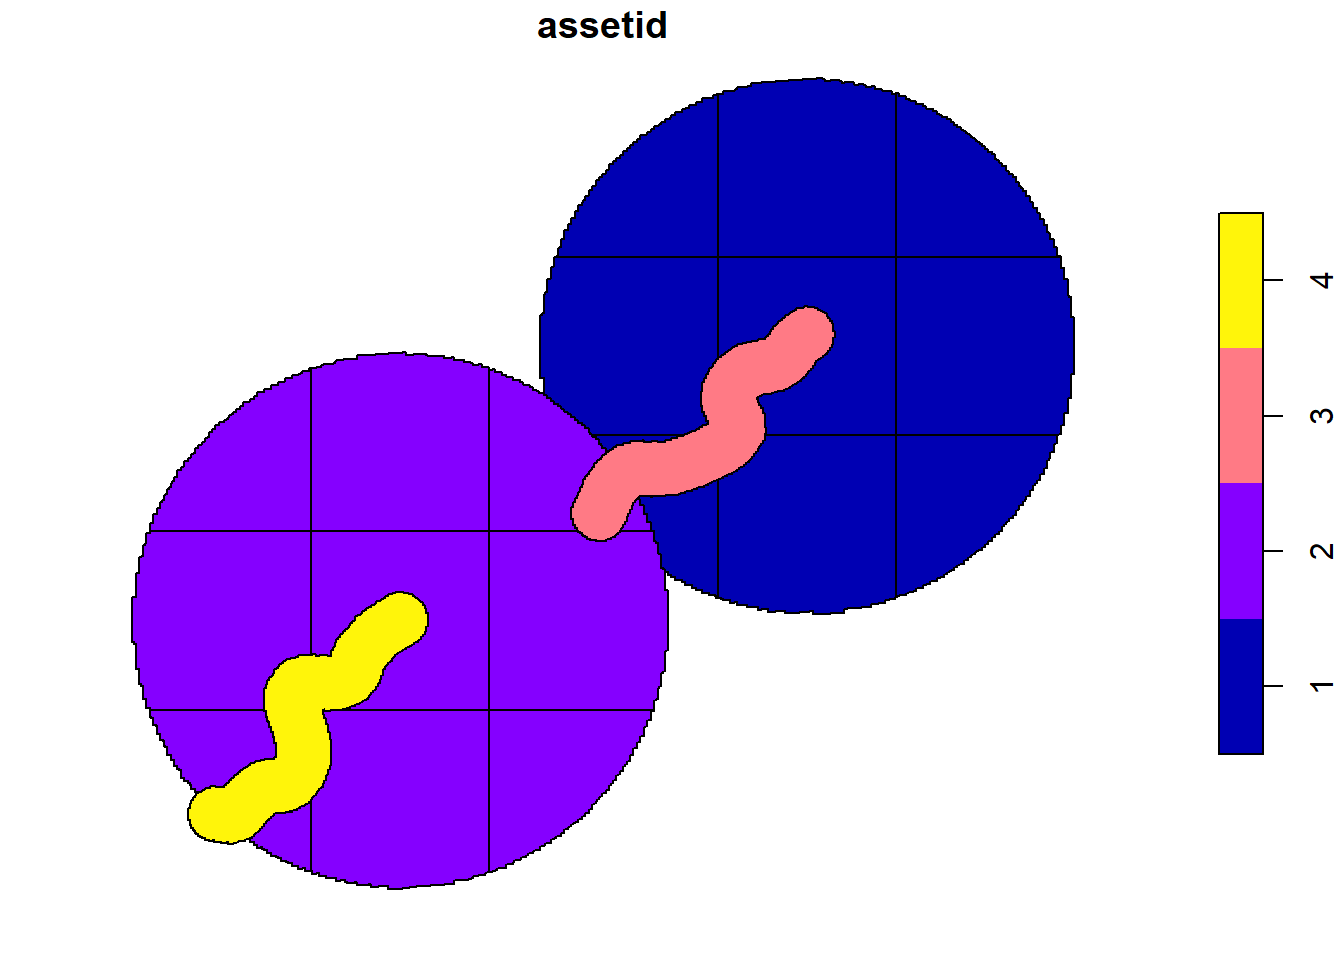

In [ ]:
area <- as.numeric(max(st_area(portfolio))) / 10000 # to ha
chunks <- mapme.biodiversity:::.chunk(portfolio, chunk_size = area / 4)
plot(chunks["assetid"])

We can put these two options together and apply them for the current R session by calling `mapme_options()` with our desired values. Check out the help page of [`mapme_options()`](https://mapme-initiative.github.io/mapme.biodiversity/dev/reference/mapme.html) to learn more about the other parameters.

In [ ]:
mapme_options(
    outdir = "./input",
    chunk_size = area / 4
)
#> Warning: PROJ: proj_create_from_name: Cannot find proj.db (GDAL error 1)
mapme_options()
#> $outdir
#> [1] "./input"
#> 
#> $chunk_size
#> [1] 198727.4
#> 
#> $retries
#> [1] 3
#> 
#> $verbose
#> [1] TRUE
#> 
#> $log_dir
#> NULL

## Fetching resources

We now make a number of resources available locally because we are aiming at calculating indicators based on those resources for the assets in our portfolio. You can explore all supported resources/indicators e.g. in the [online documentation](https://mapme-initiative.github.io/mapme.biodiversity/reference/index.html#resources).

> **Distinction between resources and indicators**
>
> A resource is a supported spatial dataset that can be made available for the extent of a portfolio via `get_resources()`. Resources can be of type vector or raster.
>
> An indicator is a function producing a tabular output for each asset in a portfolio via `calc_indicators()`. Each indicator requires one ore more resources to be available.

The code chunk below will download the resources into their respective sub-directories in `./input`. We will fetch the [transition layer](https://mapme-initiative.github.io/mapme.biodiversity/dev/reference/global_surface_water_transitions.html) from Global Surface Water (GSW) which indicates transition categories for every pixel between 1984-2021. Since we have more precise information about the timing of the dam building, we will also make available the raw [GSW timeseries](https://mapme-initiative.github.io/mapme.biodiversity/dev/reference/gsw_time_series_resource.html) which differentiates between surface water classes on a yearly basis. Since ultimately we are interested in learning about forest cover loss associated with flooding, we will also fetch data from Global Forest Watch on the [treecover density](https://mapme-initiative.github.io/mapme.biodiversity/dev/reference/gfw_treecover.html) in 2000 and the layer indicating the [year of forest loss detection](https://mapme-initiative.github.io/mapme.biodiversity/dev/reference/gfw_lossyear.html). Finally, we also fetch data from [WorldPop](https://mapme-initiative.github.io/mapme.biodiversity/dev/reference/worldpop.html) for a crude estimate of number of affected people in the spatial vicinity of the two dams.

In [ ]:
plan(multicore, workers = 4) # uses 4 workers for parallel processing
# plan(multisession, workers = 4) # use this if working in RStudio
with_progress({ # enables progress bar
    get_resources(
        portfolio,
        get_global_surface_water_transitions(version = "v1_4_2021"),
        get_gsw_time_series(years = c(2000:2019), version = "VER5-0"),
        get_gfw_treecover(version = "GFC-2023-v1.11"),
        get_gfw_lossyear(version = "GFC-2023-v1.11"),
        get_worldpop(years = 2019)
    )
})
#> Warning: package 'purrr' was built under R version 4.4.2
plan(sequential)

> **Parallel processing and progress report**
>
> `mapme.biodiversity` follows the [future paradigm](https://future.futureverse.org/) to parallel processing. That is that users are responsible to specify a strategy of how to resolve futures via [`plan()`](https://future.futureverse.org/reference/plan.html). The same applies to progress reports via [`progressr`](https://cran.r-project.org/web/packages/progressr/vignettes/progressr-intro.html) which requires users to enable progress reports.

We can inspect the resources we fetched in the previous step by preparing them for single assets. `prep_resources()` will read all fetched resources for the spatial extent of the asset that we provide to it. Note, that it will fail if you provide more than one asset!

In [ ]:
aoi <- portfolio[4, ]
resources <- prep_resources(aoi)

In [ ]:
resources
#> $global_surface_water_transitions
#> class       : SpatRaster 
#> dimensions  : 1708, 1649, 1  (nrow, ncol, nlyr)
#> resolution  : 0.00025, 0.00025  (x, y)
#> extent      : -65.01275, -64.6005, -9.64525, -9.21825  (xmin, xmax, ymin, ymax)
#> coord. ref. : lon/lat WGS 84 
#> source(s)   : memory
#> color table : 1 
#> varname     : fileb56c6ce26fda 
#> name        : transitions_70W_0Nv1_4_2021 
#> min value   :                           0 
#> max value   :                          10 
#> 
#> $gsw_time_series
#> class       : SpatRaster 
#> dimensions  : 1708, 1649, 20  (nrow, ncol, nlyr)
#> resolution  : 0.00025, 0.00025  (x, y)
#> extent      : -65.01275, -64.6005, -9.64525, -9.21825  (xmin, xmax, ymin, ymax)
#> coord. ref. : lon/lat WGS 84 
#> source(s)   : memory
#> names       : VER5-~40000, VER5-~40000, VER5-~40000, VER5-~40000, VER5-~40000, VER5-~40000, ... 
#> min values  :           0,           0,           0,           0,           0,           0, ... 
#> max values  :           3,           3,           3,           3,           3,           3, ... 
#> 
#> $gfw_treecover
#> class       : SpatRaster 
#> dimensions  : 1708, 1649, 1  (nrow, ncol, nlyr)
#> resolution  : 0.00025, 0.00025  (x, y)
#> extent      : -65.01275, -64.6005, -9.64525, -9.21825  (xmin, xmax, ymin, ymax)
#> coord. ref. : lon/lat WGS 84 
#> source(s)   : memory
#> varname     : fileb56c17dd64e7 
#> name        : Hansen_GFC-2023-v1.11_treecover2000_00N_070W 
#> min value   :                                            0 
#> max value   :                                          100 
#> 
#> $gfw_lossyear
#> class       : SpatRaster 
#> dimensions  : 1708, 1649, 1  (nrow, ncol, nlyr)
#> resolution  : 0.00025, 0.00025  (x, y)
#> extent      : -65.01275, -64.6005, -9.64525, -9.21825  (xmin, xmax, ymin, ymax)
#> coord. ref. : lon/lat WGS 84 
#> source(s)   : memory
#> varname     : fileb56c663f2221 
#> name        : Hansen_GFC-2023-v1.11_lossyear_00N_070W 
#> min value   :                                       0 
#> max value   :                                      23 
#> 
#> $worldpop
#> class       : SpatRaster 
#> dimensions  : 52, 50, 1  (nrow, ncol, nlyr)
#> resolution  : 0.008333333, 0.008333333  (x, y)
#> extent      : -65.01667, -64.6, -9.65, -9.216667  (xmin, xmax, ymin, ymax)
#> coord. ref. : lon/lat WGS 84 
#> source(s)   : memory
#> varname     : fileb56c73763c30 
#> name        : ppp_2019_1km_Aggregated 
#> min value   :                  0.0000 
#> max value   :                160.5456

In this case, all resources represent raster resources. They are read into R as `SpatRaster` objects from `terra`. Vector resources would be read as `sf` objects. The data itself is organized in directories within the `outdir` directory, which can be shared between projects because `get_resources()` will only just index those resources that match the current portfolio.

In [ ]:
fs::dir_tree("./input")
#> ./input
#> ├── gfw_lossyear
#> │   └── Hansen_GFC-2023-v1.11_lossyear_00N_070W.tif
#> ├── gfw_treecover
#> │   └── Hansen_GFC-2023-v1.11_treecover2000_00N_070W.tif
#> ├── global_surface_water_transitions
#> │   └── transitions_70W_0Nv1_4_2021.tif
#> ├── gsw_time_series
#> │   ├── VER5-0_yearlyClassification2000-0000320000-0000440000.tif
#> │   ├── VER5-0_yearlyClassification2001-0000320000-0000440000.tif
#> │   ├── VER5-0_yearlyClassification2002-0000320000-0000440000.tif
#> │   ├── VER5-0_yearlyClassification2003-0000320000-0000440000.tif
#> │   ├── VER5-0_yearlyClassification2004-0000320000-0000440000.tif
#> │   ├── VER5-0_yearlyClassification2005-0000320000-0000440000.tif
#> │   ├── VER5-0_yearlyClassification2006-0000320000-0000440000.tif
#> │   ├── VER5-0_yearlyClassification2007-0000320000-0000440000.tif
#> │   ├── VER5-0_yearlyClassification2008-0000320000-0000440000.tif
#> │   ├── VER5-0_yearlyClassification2009-0000320000-0000440000.tif
#> │   ├── VER5-0_yearlyClassification2010-0000320000-0000440000.tif
#> │   ├── VER5-0_yearlyClassification2011-0000320000-0000440000.tif
#> │   ├── VER5-0_yearlyClassification2012-0000320000-0000440000.tif
#> │   ├── VER5-0_yearlyClassification2013-0000320000-0000440000.tif
#> │   ├── VER5-0_yearlyClassification2014-0000320000-0000440000.tif
#> │   ├── VER5-0_yearlyClassification2015-0000320000-0000440000.tif
#> │   ├── VER5-0_yearlyClassification2016-0000320000-0000440000.tif
#> │   ├── VER5-0_yearlyClassification2017-0000320000-0000440000.tif
#> │   ├── VER5-0_yearlyClassification2018-0000320000-0000440000.tif
#> │   └── VER5-0_yearlyClassification2019-0000320000-0000440000.tif
#> ├── madeira.gpkg
#> ├── mapme-probe.tif
#> └── worldpop
#>     └── ppp_2019_1km_Aggregated.tif

Below, we will briefly discuss the different available resources by visualizing them spatially for the river course upstream of the Jiaru dam and discussing the different indications concerning flooding and associated tree cover loss.

### GSW Transition layer

@fig-gsw-transition displays the transition layer of GSW which contains information on change of surface water classes between the first and last years of the observation period between 1984 - 2021. In the case of the river course upstream of the Jiaru dam, we can see that the transition layer is dominated by an increase in surfaces classified as new seasonal or new permanent water cover. Other classes appear less frequently, except maybe the permanent coverage of the main river course as well as lost permanent and seasonal surfaces due to changes of where the river is flowing.

We might expect that some proportion of the new permanent/seasonal classes might be associated with the construction of the Jiaru dam, but from the transition layer alone we do not obtain more specific information about the timing of the changes within the observation period. For this, we can visualize GSW yearly classification layers, which form the basis of the transition layer.

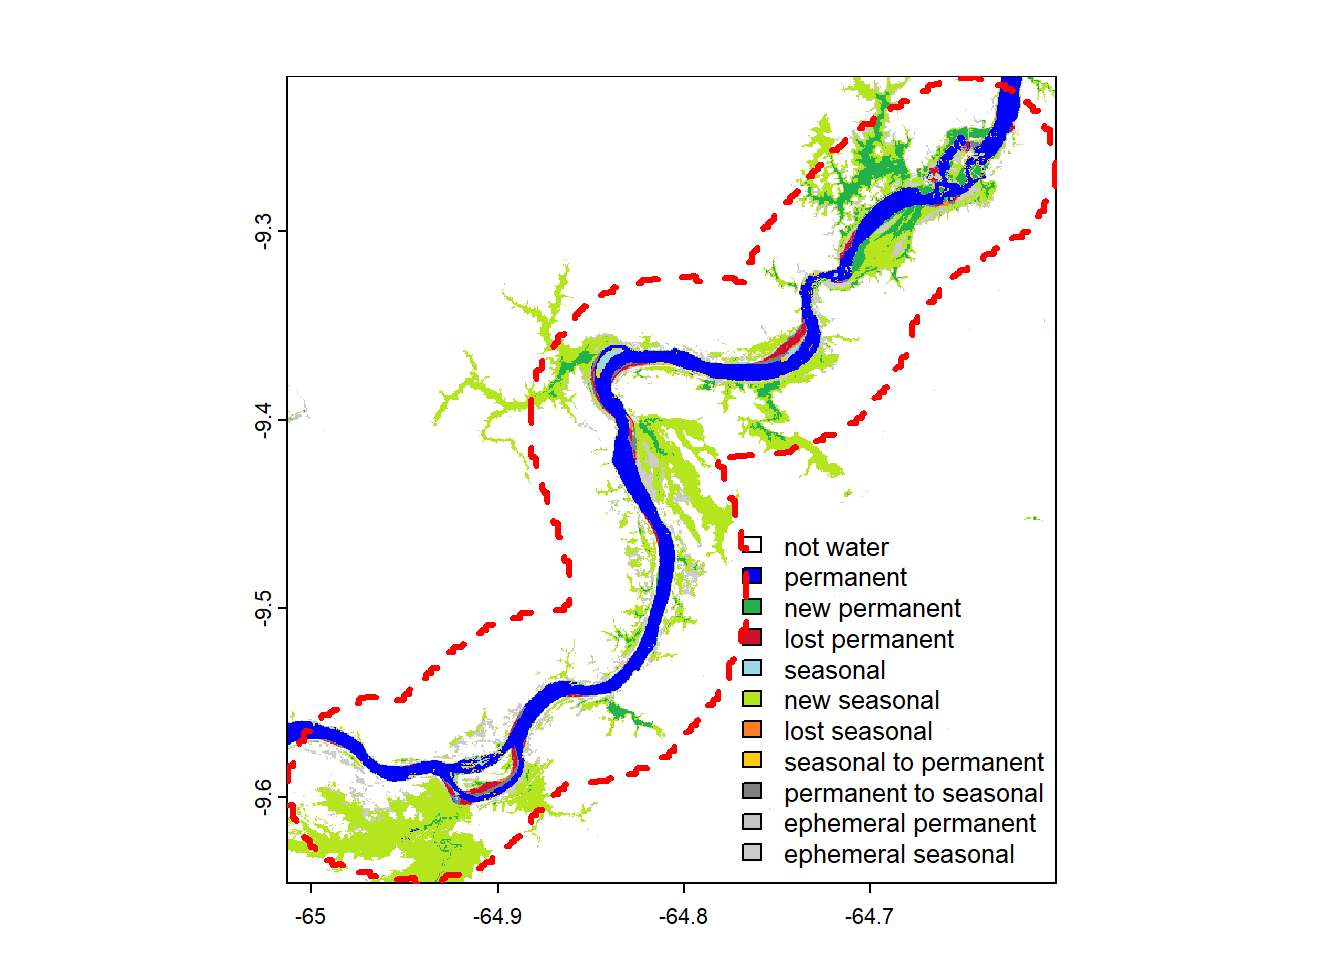

In [ ]:
p_aoi <- function(x) lines(aoi, lty = 2, lwd = 3, col = "red")

categories <- data.frame(
    value = c(0:10, 255),
    levels = c("not water", "permanent", "new permanent", "lost permanent", "seasonal", "new seasonal", "lost seasonal", "seasonal to permanent", "permanent to seasonal", "ephemeral permanent", "ephemeral seasonal", "no data"),
    colors = c("#FFFFFF", "#0000FF", "#22B14C", "#D1102D", "#99D9EA", "#B5E61D", "#E6A1AA", "#FF7F27", "#FFC90E", "#7F7F7F", "#C3C3C3", "#CCCCCC")
)

transitions <- resources$global_surface_water_transitions
coltab(transitions) <- NULL
levels(transitions) <- categories[ ,1:2] 
plot(transitions, col = categories[ ,3], fun = p_aoi, legend = "bottomright")

### GSW time series

@fig-gsw-timeseries-2007 indicates the GSW classification for the year 2007 differentiating between surface covered by water (seasonal and permanent) and water free surfaces (no observations and no water). We can see that surfaces seasonally covered by water strictly follow the river course and cover only a very small fraction while the permanent water coverage following the main river course dominates the picture.

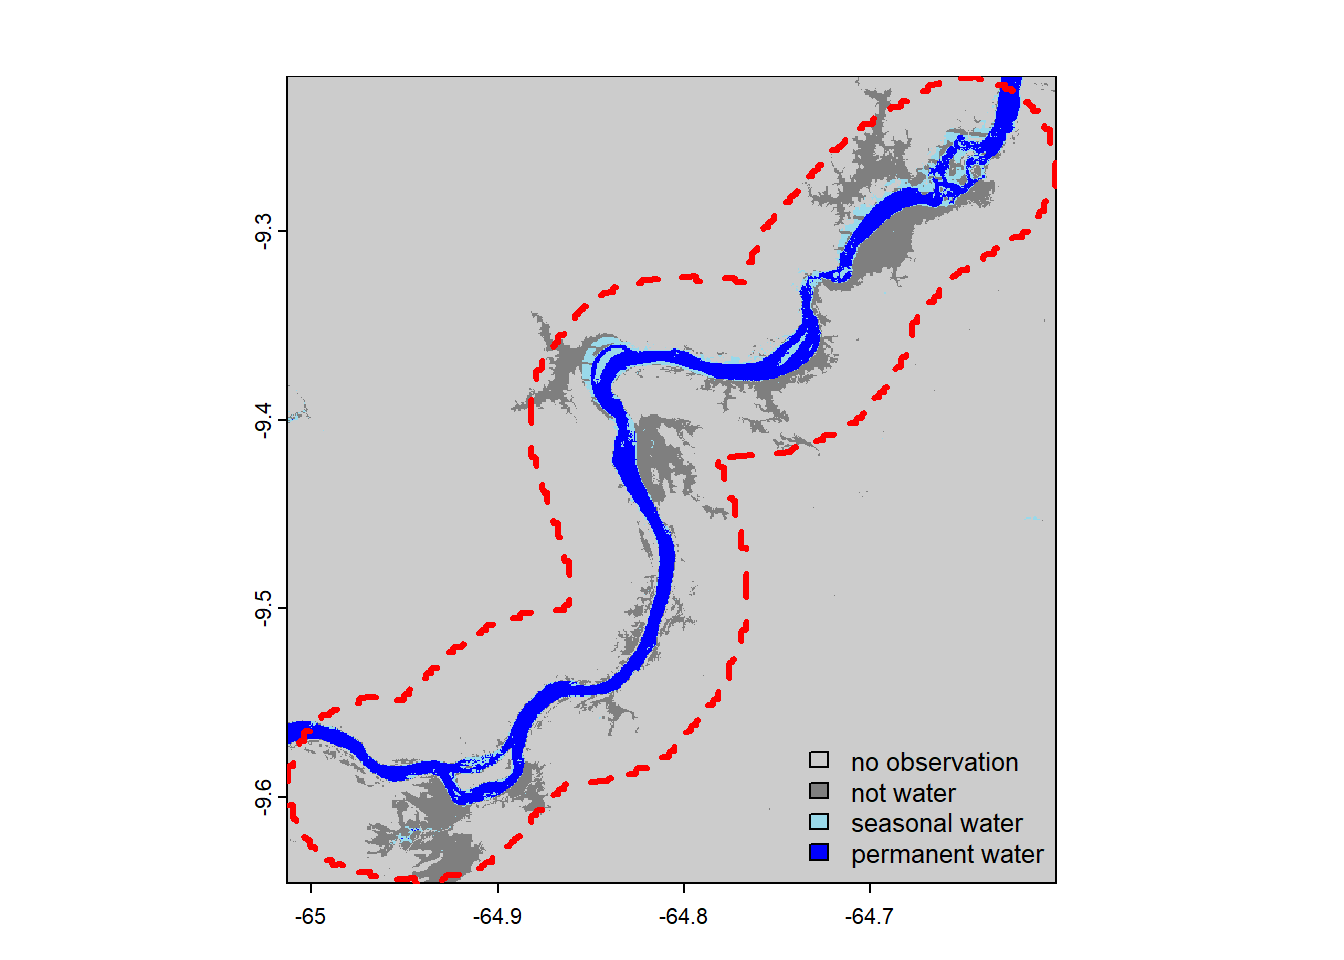

In [ ]:
levels <- c("no observation", "not water", "seasonal water", "permanent water")
colors <- c("#CCCCCC", "#7F7F7F", "#99D9EA", "#0000FF")
plot(resources$gsw_time_series[[8]], col = colors, type = "classes", levels = levels, fun = p_aoi, legend = "bottomright")

@fig-gsw-timeseries-2017 displays the GSW classification layer for the year 2017. We see a substantial increase of surfaces seasonally covered by water compared to the classification of 2007. Also, especially in the North close to the dam location, we also see an increase of the surface that is permanently covered by water.

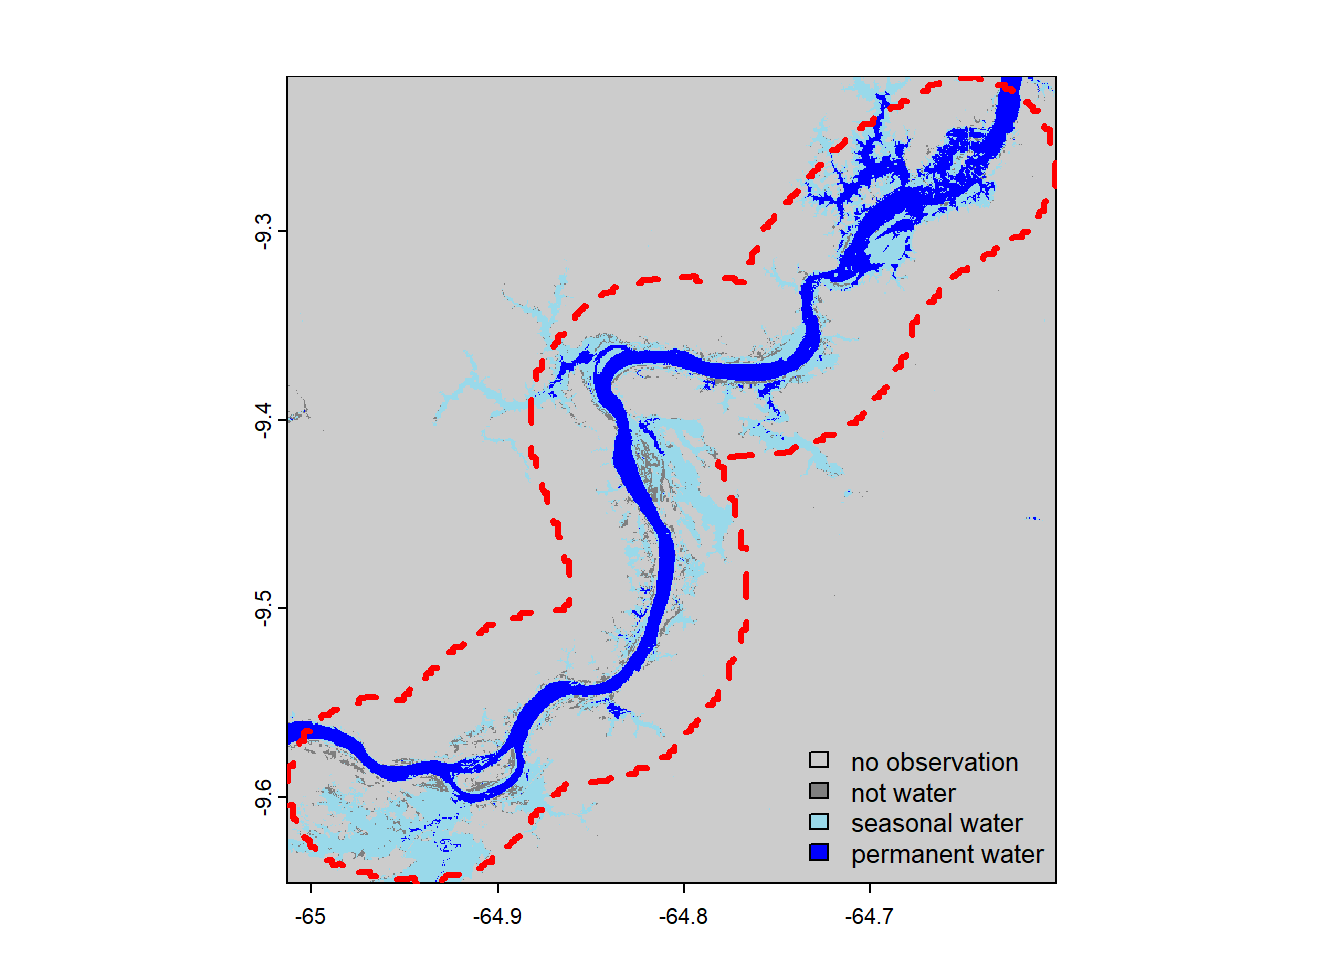

In [ ]:
plot(resources$gsw_time_series[[18]], col = colors, type = "classes", levels = levels, fun = p_aoi, legend = "bottomright")

We thus obtained a first indication that the newly flooded areas are quite significant and that they occurred after the construction of the Jiaru dam. However, until now we have no information of the land cover of these flooded areas with regard to if forest cover was lost due to the flooding. For this, we will visualize GFW treecover and lossyear layers.

### GFW Tree Cover 2000

@fig-gfw-treecover displays the tree cover layer from GFW. It indicates the percentage of canopy coverage per pixel for the year 2000. We see that to the North of the river the canopy cover is really dense (~100%) while we see parts with lower canopy cover on the South of the river banks. There, we can also see lower densities in proximity to linear structures that indicates potential human-driven deforestation along roads that already occurred prior to the year 2000.

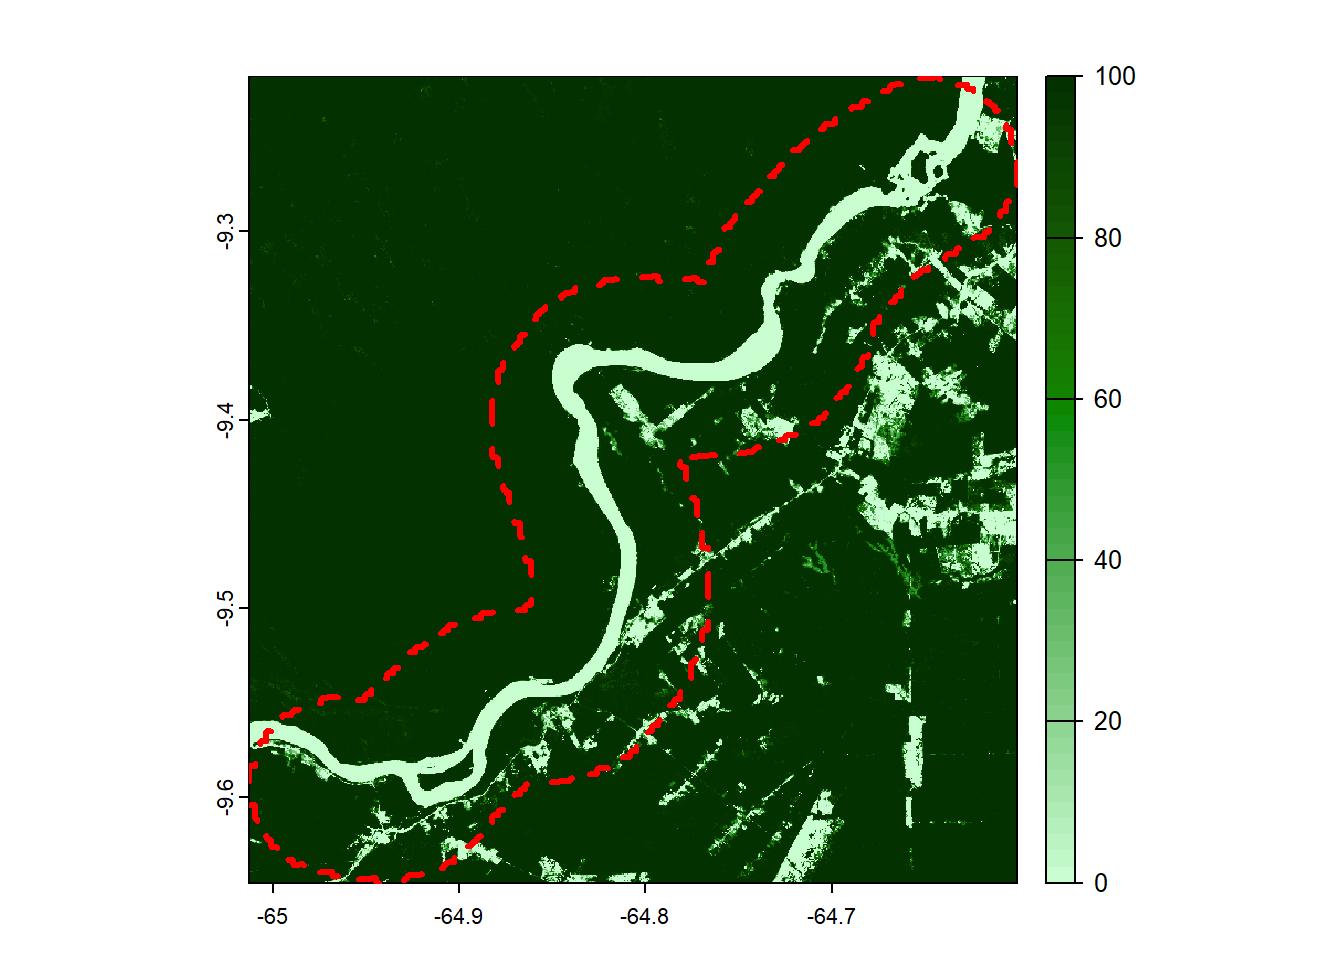

In [ ]:
plot(resources$gfw_treecover, col = rev(map.pal("grass")), fun = p_aoi)

@fig-gfw-lossyear shows the year of forest cover loss detected by GFW between 2000 and 2023. Orang-ish to yellow colors represent loss occurrences before 2010 while green to blue-ish colors indicated losses towards 2023. Here, again, we see distinct patterns between the North and the South of the river bank. To the North, we observe a domination of tree cover loss between 2010 and 2015 in more naturally shaped areas - an indication of tree cover loss associated with flooding the lowest areas as a result of raising water levels. To the South, we observe both, tree cover losses before and after 2010 mostly occurring in rectangular shapes, again an indication of human-driven deforestation in that areas.

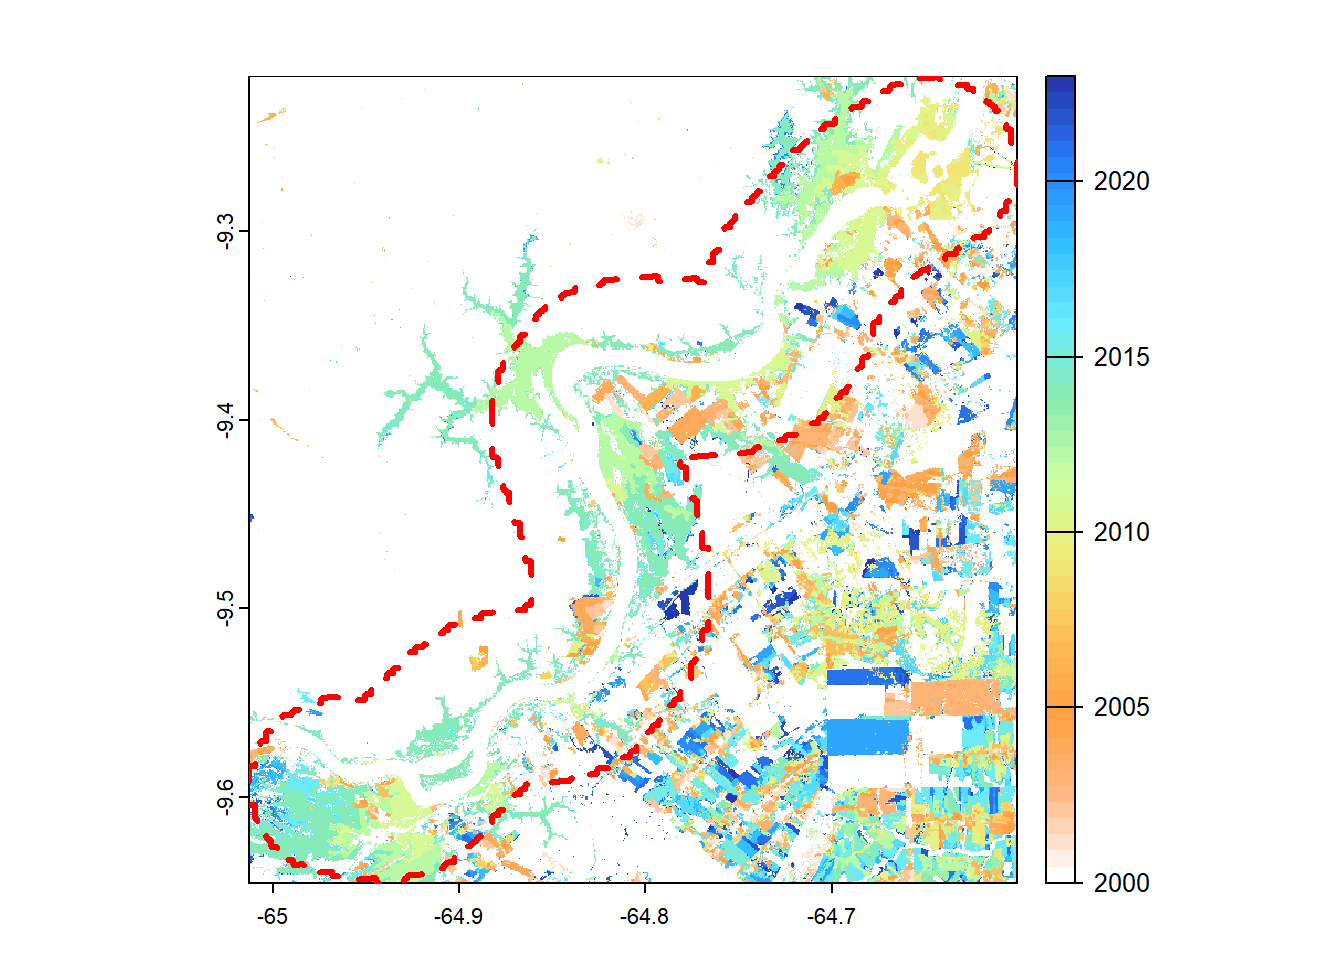

In [ ]:
plot(resources$gfw_lossyear + 2000, col = rev(map.pal("haxby")), fun = p_aoi)

## Calculating indicators

An indicator requires at least a single resource to be available via `get_resources()`. You can search through the available indicators and learn about their required arguments e.g. in the [online documentation](https://mapme-initiative.github.io/mapme.biodiversity/reference/index.html#indicators).

Below, we calculate several indicators that we will base our further analysis on. Note, that we wrap our code in `plan()` to enable parallel processing as well as `with_progress()` to enable a progress bar (only visible in an interactive R session). When calling `calc_indicators()`, we split up our original portfolio in two parts: one for buffers of the upstream river courses and the other one for the 50 km circular buffers around the dam locations. We calculate a distinct set of indicators for each: a timeseries of forest cover and surface water as well as the surface water transition classes for the upstream rivers courses and the population count only for the dam buffers.

In [ ]:
plan(multicore, workers = 4) # uses 4 workers for parallel processing
# plan(multisession, workers = 4) # use this if working in RStudio
with_progress({ # enables progress bar
    upstreams <- calc_indicators(
        filter(portfolio, type == "upstream"),
        calc_treecover_area(years = 2000:2019, min_size = 1, min_cover = 10),
        calc_gsw_time_series(),
        calc_gsw_transitions()
    )
    buffers <- calc_indicators(
        filter(portfolio, type == "buffer"),
        calc_population_count(stats = "sum")
    )
})
plan(sequential) # closes idle processes

After the successful indicator calculation, we rowwise-bind together the resulting objects. If we inspect the portfolio object, we can observe that indicators are added as nested-list columns to our portfolio. In case an indicator is not present for a certain asset `bind_rows()` will fill in a `NULL` value. We can see, that the objects within the indicator columns are `tibble`s. When inspecting the first one for the `treecover_area` indicator, we see that it has the column names `datetime`, `variable`, `unit` and `value`. This data model is used for every indicator in `mapme.biodiversity` and allows an easy integration into further analysis workflows as we will see below.

### Serializing portfolios to disk

In [ ]:
inds_portfolio <- bind_rows(upstreams, buffers)
inds_portfolio
#> Simple feature collection with 4 features and 8 fields
#> Geometry type: POLYGON
#> Dimension:     XY
#> Bounding box:  xmin: -65.10765 ymin: -9.72112 xmax: -63.4921 ymax: -8.348096
#> Geodetic CRS:  WGS 84 (CRS84)
#> # A tibble: 4 × 9
#>   name          start_flooding      type   assetid treecover_area gsw_timeseries
#> * <chr>         <dttm>              <chr>    <int> <list>         <list>        
#> 1 Santo Antonio 2011-01-01 00:00:00 upstr…       3 <tibble>       <tibble>      
#> 2 Jirau         2013-01-01 00:00:00 upstr…       4 <tibble>       <tibble>      
#> 3 Santo Antonio 2011-01-01 00:00:00 buffer       1 <NULL>         <NULL>        
#> 4 Jirau         2013-01-01 00:00:00 buffer       2 <NULL>         <NULL>        
#> # ℹ 3 more variables: gsw_transitions <list>, geometry <POLYGON [°]>,
#> #   population_count <list>
head(inds_portfolio$treecover_area[[1]])
#> # A tibble: 6 × 4
#>   datetime            variable  unit   value
#>   <dttm>              <chr>     <chr>  <dbl>
#> 1 2000-01-01 00:00:00 treecover ha    50695.
#> 2 2001-01-01 00:00:00 treecover ha    50229.
#> 3 2002-01-01 00:00:00 treecover ha    49511.
#> 4 2003-01-01 00:00:00 treecover ha    48674.
#> 5 2004-01-01 00:00:00 treecover ha    48013.
#> 6 2005-01-01 00:00:00 treecover ha    46485.

We can serialize a portfolio object to a GeoPackage (GPKG) on disk by using the `write_portfolio()` utility.

In [ ]:
dsn <- "./output/portfolio.gpkg"
if (file.exists(dsn)) file.remove(dsn)
write_portfolio(inds_portfolio, dsn = dsn)

This will create a GPKG with two layers called `metadata` and `indicators`. The `metadata` table will contain all flat attributes (e.g. non-nested list columns) plus the geo-information while the `indicator` table contain all indicators with our known indicator column names in a long format. It is the variable `assetid` identifying the corresponding indicator data for each asset.

In [ ]:
st_layers(dsn)
#> Driver: GPKG 
#> Available layers:
#>   layer_name geometry_type features fields       crs_name
#> 1   metadata       Polygon        4      4 WGS 84 (CRS84)
#> 2 indicators            NA      222      6           <NA>
read_sf(dsn, layer = "metadata")
#> Simple feature collection with 4 features and 4 fields
#> Geometry type: POLYGON
#> Dimension:     XY
#> Bounding box:  xmin: -65.10765 ymin: -9.72112 xmax: -63.4921 ymax: -8.348096
#> Geodetic CRS:  WGS 84 (CRS84)
#> # A tibble: 4 × 5
#>   name          start_flooding      type     assetid                        geom
#>   <chr>         <dttm>              <chr>      <int>               <POLYGON [°]>
#> 1 Santo Antonio 2011-01-01 00:00:00 upstream       3 ((-64.31941 -9.13046, -64.…
#> 2 Jirau         2013-01-01 00:00:00 upstream       4 ((-64.9534 -9.643272, -64.…
#> 3 Santo Antonio 2011-01-01 00:00:00 buffer         1 ((-63.58061 -8.538803, -63…
#> 4 Jirau         2013-01-01 00:00:00 buffer         2 ((-64.90595 -9.637122, -64…
read_sf(dsn, layer = "indicators")
#> # A tibble: 222 × 6
#>    assetid indicator      datetime            variable  unit   value
#>      <int> <chr>          <dttm>              <chr>     <chr>  <dbl>
#>  1       3 treecover_area 2000-01-01 00:00:00 treecover ha    50695.
#>  2       3 treecover_area 2001-01-01 00:00:00 treecover ha    50229.
#>  3       3 treecover_area 2002-01-01 00:00:00 treecover ha    49511.
#>  4       3 treecover_area 2003-01-01 00:00:00 treecover ha    48674.
#>  5       3 treecover_area 2004-01-01 00:00:00 treecover ha    48013.
#>  6       3 treecover_area 2005-01-01 00:00:00 treecover ha    46485.
#>  7       3 treecover_area 2006-01-01 00:00:00 treecover ha    45933.
#>  8       3 treecover_area 2007-01-01 00:00:00 treecover ha    45379.
#>  9       3 treecover_area 2008-01-01 00:00:00 treecover ha    45234.
#> 10       3 treecover_area 2009-01-01 00:00:00 treecover ha    44609.
#> # ℹ 212 more rows

While you could join those tables manually, the `read_portfolio()` utility automatically takes care of re-constructing the original portfolio object from the output GPKG:

In [ ]:
(inds_portfolio <- read_portfolio(dsn))
#> Simple feature collection with 4 features and 8 fields
#> Geometry type: POLYGON
#> Dimension:     XY
#> Bounding box:  xmin: -65.10765 ymin: -9.72112 xmax: -63.4921 ymax: -8.348096
#> Geodetic CRS:  WGS 84 (CRS84)
#> # A tibble: 4 × 9
#>   name          start_flooding      type   assetid treecover_area gsw_timeseries
#>   <chr>         <dttm>              <chr>    <int> <list>         <list>        
#> 1 Santo Antonio 2011-01-01 00:00:00 upstr…       3 <tibble>       <tibble>      
#> 2 Jirau         2013-01-01 00:00:00 upstr…       4 <tibble>       <tibble>      
#> 3 Santo Antonio 2011-01-01 00:00:00 buffer       1 <NULL>         <NULL>        
#> 4 Jirau         2013-01-01 00:00:00 buffer       2 <NULL>         <NULL>        
#> # ℹ 3 more variables: gsw_transitions <list>, population_count <list>,
#> #   geom <POLYGON [°]>

> **Sparse indicator table**
>
> The indicator table represents the available indicator data as a sparsely. That means that you will only find entries there for an asset-indicator combination which has an actual value. That means that you must take care of filling up missing asset-indicator combinations with `NULL` if you decide to manually join with the `metadata` table.

### Downstream analysis of indicator data

Most indicators in `mapme.biodiversity` represent some sort of zonal statistic, meaning that the spatial dimension of the input data will be aggregated to the extent of the assets in a portfolio. We can, for example, analyze these indicator by visualizing them using `ggplot2`.

@fig-gg-gsw-transitions shows the areal distribution of GSW transition classes upstream of the two dams of interest. We see an substantial increase of seasonal surface water in Jirau of \> 10,000 ha, but also increases in the permanent surface water class which sum up to 6,500 ha in total. The ephemeral seasonal class also covers a substantial share of areas. It represents surfaces which transitioned from no water to seasonal water sometime in the observation period, but returned to no water cover before the end of that period.

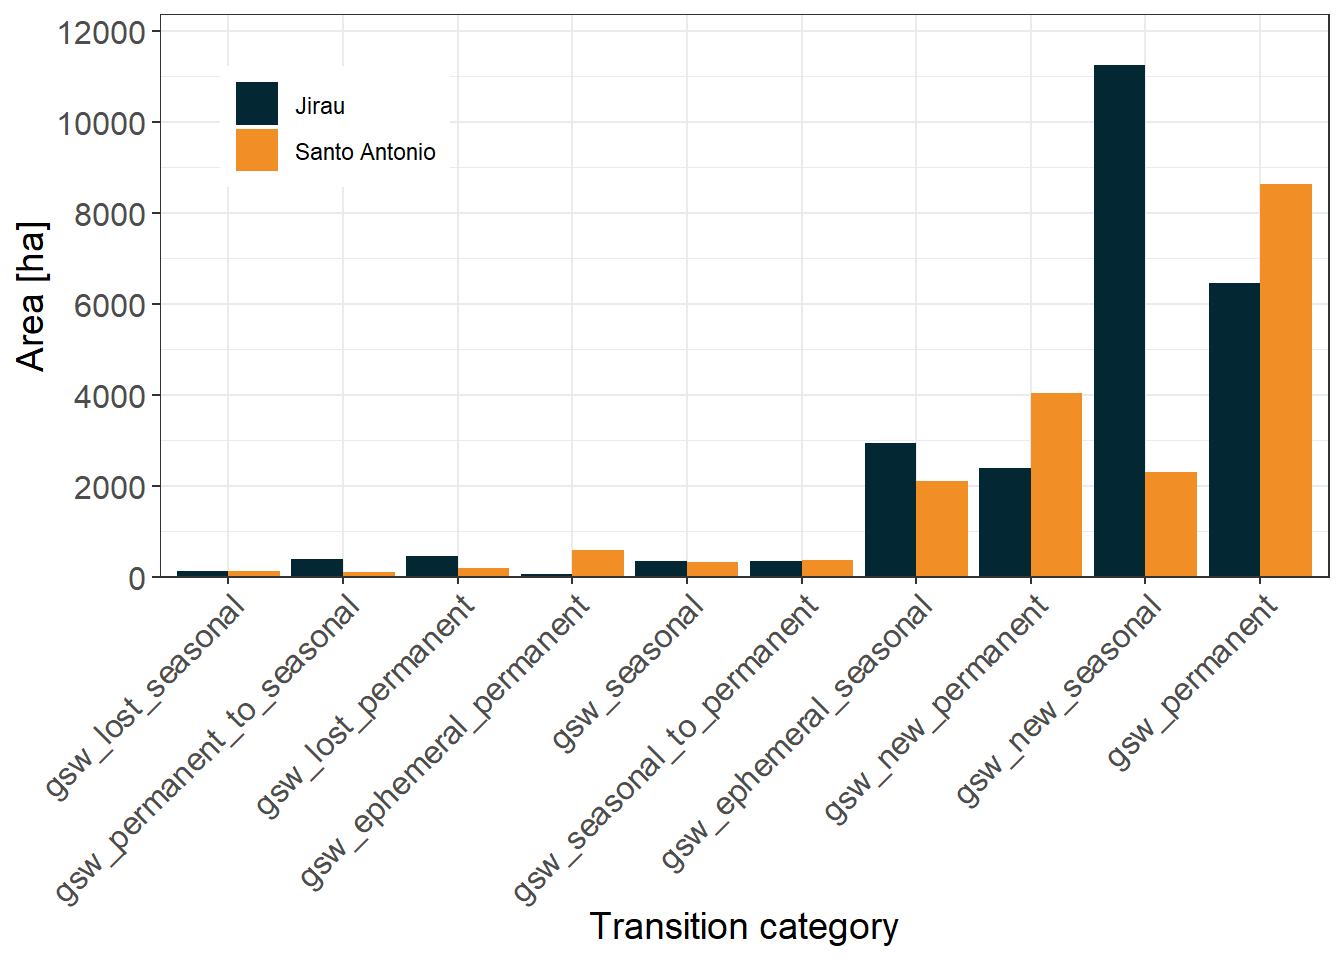

In [ ]:
upstreams$gsw_transitions[[1]]
#> # A tibble: 10 × 4
#>    datetime            variable                  unit  value
#>    <dttm>              <chr>                     <chr> <dbl>
#>  1 2021-01-01 00:00:00 gsw_permanent             ha    8644.
#>  2 2021-01-01 00:00:00 gsw_new_permanent         ha    4052.
#>  3 2021-01-01 00:00:00 gsw_lost_permanent        ha     189.
#>  4 2021-01-01 00:00:00 gsw_seasonal              ha     317.
#>  5 2021-01-01 00:00:00 gsw_new_seasonal          ha    2296.
#>  6 2021-01-01 00:00:00 gsw_lost_seasonal         ha     139.
#>  7 2021-01-01 00:00:00 gsw_seasonal_to_permanent ha     376.
#>  8 2021-01-01 00:00:00 gsw_permanent_to_seasonal ha     107.
#>  9 2021-01-01 00:00:00 gsw_ephemeral_permanent   ha     595.
#> 10 2021-01-01 00:00:00 gsw_ephemeral_seasonal    ha    2103.

my_theme <- function() {
    theme_bw() +
        theme(
        legend.position = "inside",
        legend.title = element_blank(),
        legend.position.inside = c(.15, .80),
        axis.text = element_text(size = 12, ),
        axis.title = element_text(size = 14),
        axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)
    )
}

colors <- c("#032733", "#f18e26")

upstreams |>
    portfolio_long(indicators = "gsw_transitions", drop_geoms = TRUE) |>
    mutate(variable = forcats::fct_reorder(variable, value)) |>
    ggplot(aes(x = variable, y = value, fill = name)) +
    geom_bar(stat = "identity", position = "dodge") +
    scale_fill_manual(values = colors) +
    scale_y_continuous(breaks = seq(0, 12000, 2000), expand = expansion(mult = c(0, .1))) +
    labs(x = "Transition category", y = "Area [ha]", fill = "Location") +
    my_theme()

From the GSW transition indicator, we are still not obtaining any information on the timing of these changes. For this, we are going to visualize the two most important classes, namely permanent and seasonal water surfaces, over time. @fig-gg-gsw-ts shows that prior to 2011, the surface which was permanently covered by water was relatively stable for both upstream river courses. That changes for the Santo Antonio dam abruptly in 2012, where we observe a steep increase from ~9,000 ha to 13,500 ha of areas permanently covered in water. For the Jirau, the increase is delayed by a year and also with lower magnitude with an increase of about 3,000 ha. This pattern is, however, reversed with the seasonal water class were we see an absolute increase of about 10,000 ha for Jiaru while only about 2,000 ha for Santo Antonio.

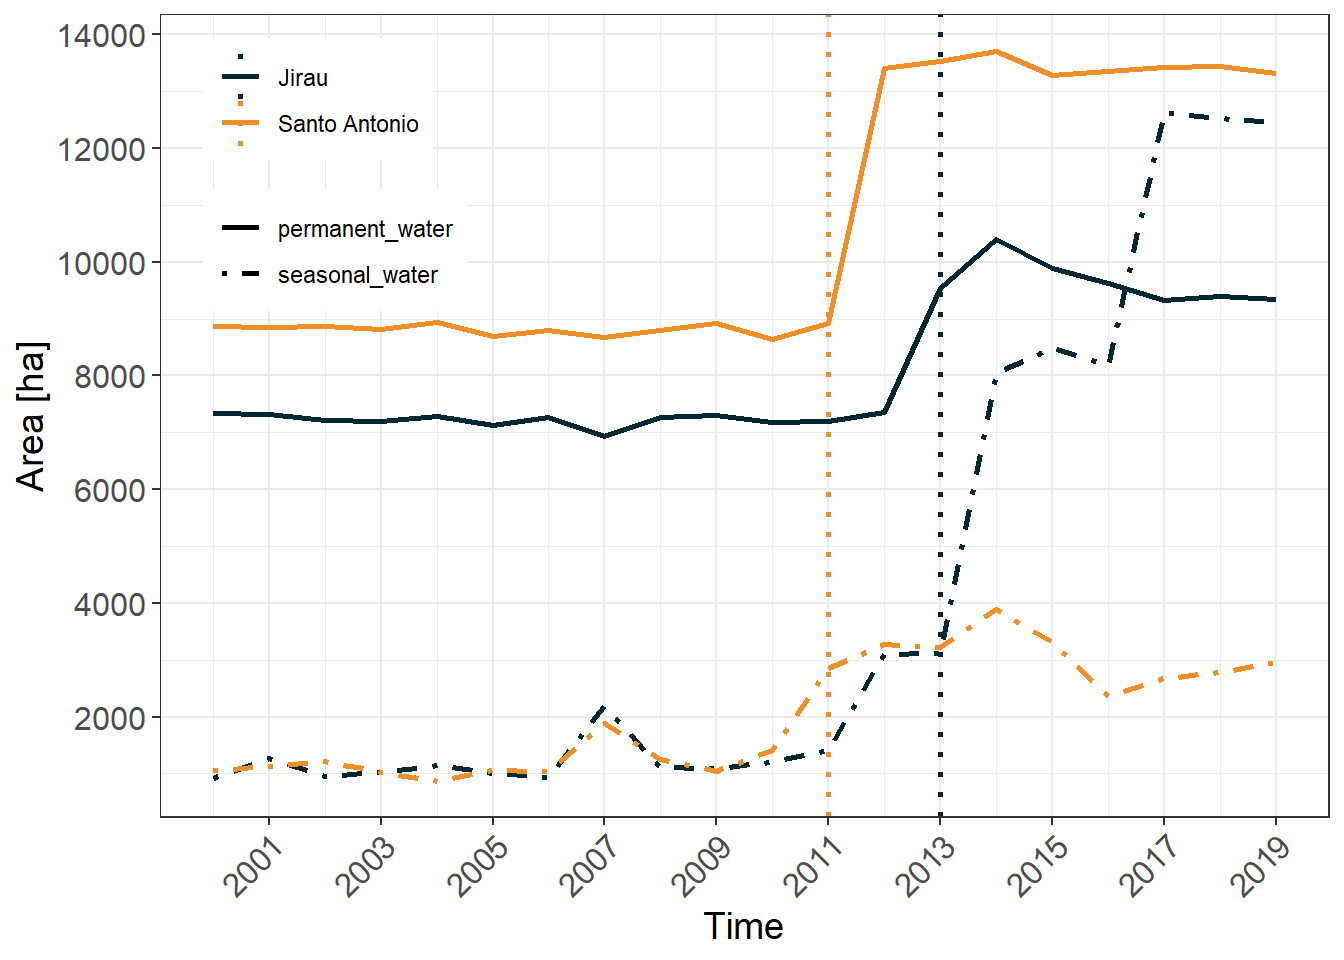

In [ ]:
upstreams$gsw_timeseries[[1]]
#> # A tibble: 80 × 4
#>    datetime            variable        unit   value
#>    <dttm>              <chr>           <chr>  <dbl>
#>  1 2000-01-01 00:00:00 no_observations ha    51647.
#>  2 2001-01-01 00:00:00 no_observations ha    51649.
#>  3 2002-01-01 00:00:00 no_observations ha    51648.
#>  4 2003-01-01 00:00:00 no_observations ha    51655.
#>  5 2004-01-01 00:00:00 no_observations ha    51648.
#>  6 2005-01-01 00:00:00 no_observations ha    51650.
#>  7 2006-01-01 00:00:00 no_observations ha    51649.
#>  8 2007-01-01 00:00:00 no_observations ha    51648.
#>  9 2008-01-01 00:00:00 no_observations ha    51648.
#> 10 2009-01-01 00:00:00 no_observations ha    51649.
#> # ℹ 70 more rows

upstreams |>
    portfolio_long(indicators = "gsw_timeseries", drop_geoms = TRUE) |>
    filter(!variable %in% c("no_observations", "not_water")) |>
    ggplot(aes(x = datetime, y = value, color = name, linetype = variable)) +
    geom_line(lwd = 1) +
    geom_vline(aes(xintercept = start_flooding, color = name), lwd = 1, linetype = 3) +
    scale_linetype_manual(values = c(1, 4)) +
    scale_color_manual(values = colors) +
    scale_x_datetime(date_labels = "%Y", date_breaks = "2 years", date_minor_breaks = "1 years")  +
    scale_y_continuous(breaks = seq(0, 14000, 2000)) +
    labs(x = "Time", y = "Area [ha]", color = "Location", linetype = "Category") +
    my_theme() 

We now finally analyze if the observed forest cover loss corresponds to those changes in surface water. @fig-gg-treecover-loss shows cumulative forest losses for both upstream river courses between 2000 and 2019. We see a steep increase in forest losses between 2009 and 2012 for the Santo Antonio river course which closely follows the pattern of the permanent water class in @fig-gg-gsw-ts leveling out towards the end of the observation period. During this time, we observe tree cover losses of about 8,000 ha.

For the Jirau river course, the tree cover loss closely mirrors the dynamic of the seasonal water surface class with a steep increase between 2009 and 2017. During the same time, forest cover losses amount to ~18,000 ha.

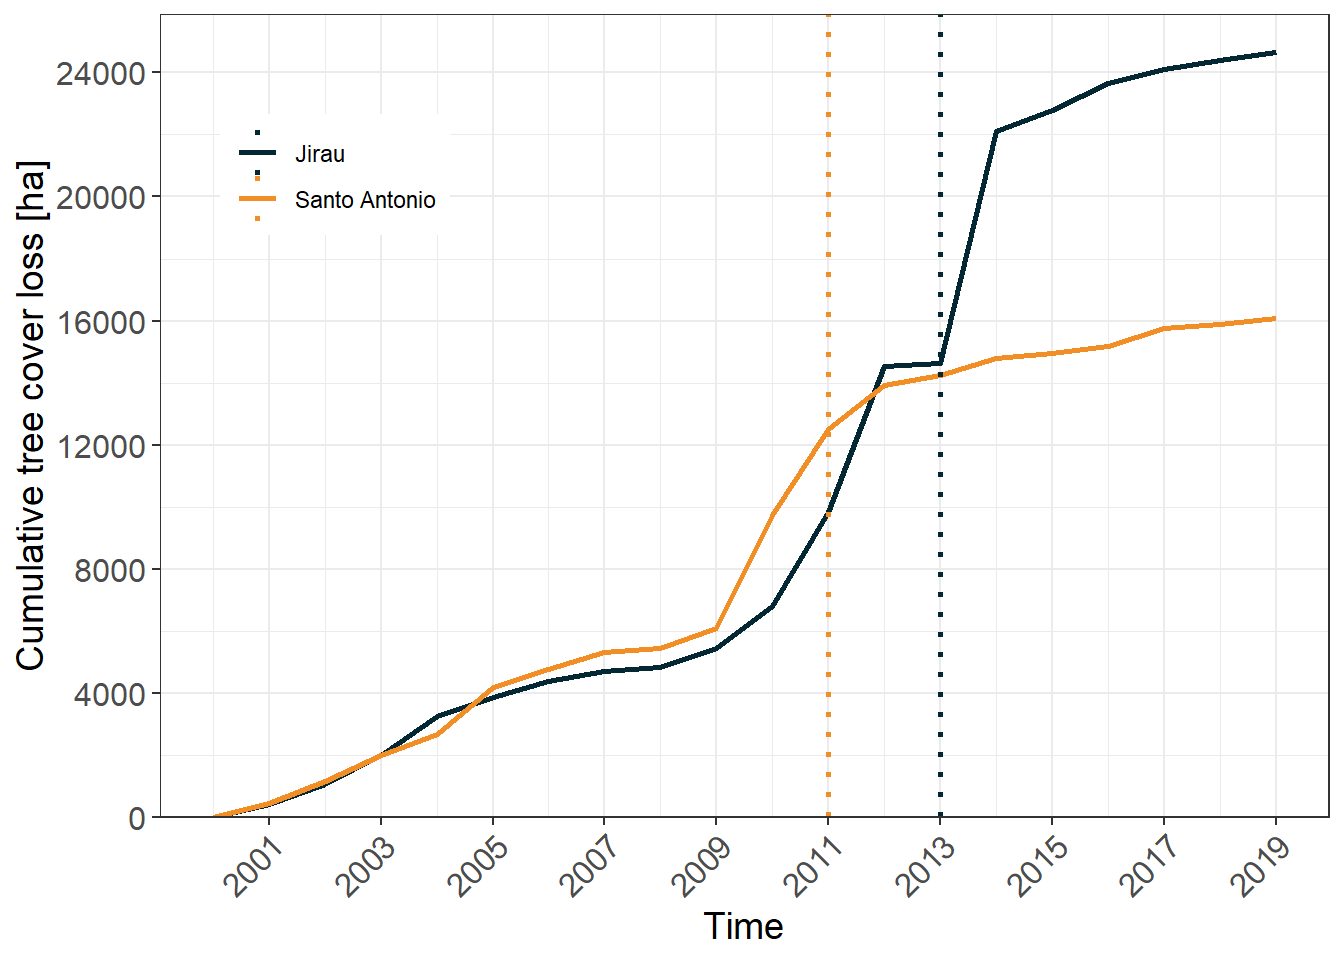

In [ ]:
upstreams$treecover_area[[1]]
#> # A tibble: 20 × 4
#>    datetime            variable  unit   value
#>    <dttm>              <chr>     <chr>  <dbl>
#>  1 2000-01-01 00:00:00 treecover ha    50695.
#>  2 2001-01-01 00:00:00 treecover ha    50229.
#>  3 2002-01-01 00:00:00 treecover ha    49511.
#>  4 2003-01-01 00:00:00 treecover ha    48674.
#>  5 2004-01-01 00:00:00 treecover ha    48013.
#>  6 2005-01-01 00:00:00 treecover ha    46485.
#>  7 2006-01-01 00:00:00 treecover ha    45933.
#>  8 2007-01-01 00:00:00 treecover ha    45379.
#>  9 2008-01-01 00:00:00 treecover ha    45234.
#> 10 2009-01-01 00:00:00 treecover ha    44609.
#> 11 2010-01-01 00:00:00 treecover ha    40959.
#> 12 2011-01-01 00:00:00 treecover ha    38192.
#> 13 2012-01-01 00:00:00 treecover ha    36774.
#> 14 2013-01-01 00:00:00 treecover ha    36432.
#> 15 2014-01-01 00:00:00 treecover ha    35908.
#> 16 2015-01-01 00:00:00 treecover ha    35751.
#> 17 2016-01-01 00:00:00 treecover ha    35506.
#> 18 2017-01-01 00:00:00 treecover ha    34940.
#> 19 2018-01-01 00:00:00 treecover ha    34818.
#> 20 2019-01-01 00:00:00 treecover ha    34601.

upstreams |>
    portfolio_long(indicators = "treecover_area", drop_geoms = TRUE) |>
    mutate(loss = cumsum(abs(c(0, diff(value)))), .by = name) |>
    ggplot(aes(x = datetime, y = loss, color = name)) +
    geom_line(lwd = 1) +
    geom_vline(aes(xintercept = start_flooding, color = name), lwd = 1, linetype = 3) +
    scale_color_manual(values = colors) +
    scale_x_datetime(date_labels = "%Y", date_breaks = "2 years", date_minor_breaks = "1 years")  +
    scale_y_continuous(breaks = seq(0, 24000, 4000), expand = expansion(mult = c(0, .05))) +
    labs(x = "Time", y = "Cumulative tree cover loss [ha]", color = "Location") +
    my_theme() 

With this we have some solid indication that treecover loss in both AOIs between 2007 to 2017 was mainly dominated by losses associated with flooding previously forested areas. However, as can be seen from the spatial visualization of the treecover loss year (@fig-gfw-lossyear) there might also be other processes at work here contributing to the deforestation rates. An option to improve the presented methodology could be to spatially match the yearly surface water change maps with the treecover loss layer to construct a new indicator that calculates the area of treecover loss due to flooding.

Lastly, we will take a look at the number of people living in a 50 km vicinity of the dams locations. For this, we will use another utility, called `portfolio_wide()`, which unpacks nested indicator columns to create a wide view of our portfolio data. Note, that the column names are quite predictable, though not perfectly legible.

We see that WorldPop estimates about 500,000 people to live in the buffer zone of the Santo Antonio dam while only about 20,000 in the vicinity of the Jiaru dam. Looking up the number of inhabitants in [Porto Velho](https://datacommons.org/place/wikidataId/Q172512?utm_medium=explore&mprop=count&popt=Person&hl=en#) shows a pretty good level of agreement for this estimate.

In [ ]:
buffers |>
  select(assetid, name, type, population_count) |>
  portfolio_wide()
#> Simple feature collection with 2 features and 4 fields
#> Geometry type: POLYGON
#> Dimension:     XY
#> Bounding box:  xmin: -65.10765 ymin: -9.72112 xmax: -63.4921 ymax: -8.348096
#> Geodetic CRS:  WGS 84 (CRS84)
#> # A tibble: 2 × 5
#>   assetid name          type   population_count_2019…¹                  geometry
#>     <dbl> <chr>         <chr>                    <dbl>             <POLYGON [°]>
#> 1       1 Santo Antonio buffer                 499234. ((-63.58061 -8.538803, -…
#> 2       2 Jirau         buffer                  20036. ((-64.90595 -9.637122, -…
#> # ℹ abbreviated name: ¹​`population_count_2019-01-01_population_sum_count`

## Get Involved

The contents of this workshop are strongly based on the `mapme.biodiversity` package. If you’re interested in the inner workings of the package, you can further explore it on [GitHub](https://github.com/mapme-initiative/mapme.biodiversity). On there, you can also learn more about how to extend the package to work with custom datasets. You can also report (and fix) bugs you encounter or get involved in discussions about upcoming features. You can also find other repositories on our [GitHub organization](https://github.com/mapme-initiative), featuring further use cases and useful helper tools.

## References